## 🔍 **Paso 1: Análisis Exploratorio de Datos (EDA)**

### 🧩 Suposición del dataset

Vamos a trabajar con un dataset que tiene una estructura similar a:

| timestamp           | potencia |
| ------------------- | ------------ |
| 2024-04-01 00:00:00 | 0.42         |
| 2024-04-01 00:15:00 | 0.38         |
| 2024-04-01 00:30:00 | 0.40         |
| ...                 | ...          |

Frecuencia: cada 1 minuto.

---

### 📊 1. Visualización inicial


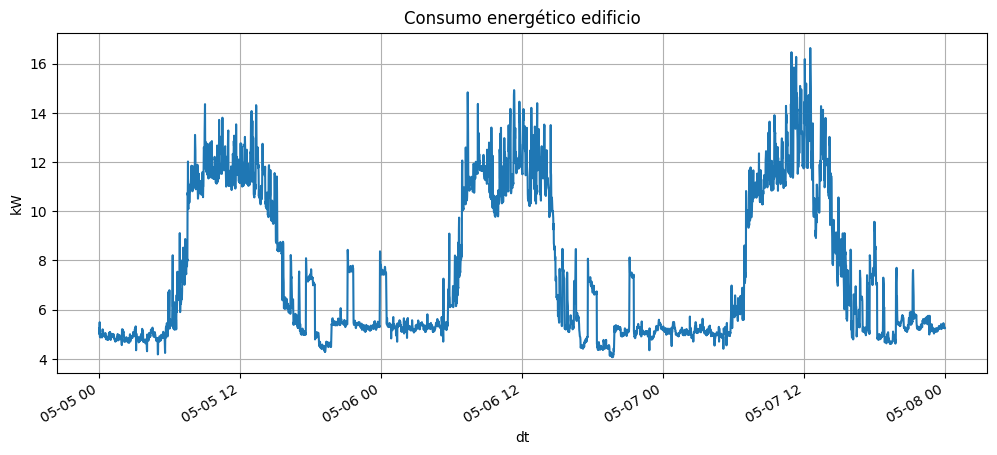

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("scripts/pipeline_energia_iot/data/consumo_potencia_min.csv", parse_dates=["dt"])
df.set_index("dt", inplace=True)

plt.figure(figsize=(12, 5))
df["potencia"].plot(title="Consumo energético edificio")
plt.ylabel("kW")
plt.grid()
plt.show()

### 🧠 2. Tipos de anomalías frecuentes en consumo energético

| Tipo de anomalía                 | Descripción                                                                    |
| -------------------------------- | ------------------------------------------------------------------------------ |
| 🔺 **Valores fuera de rango**    | picos inesperados muy por encima del valor típico. Ej: 10x el valor normal.    |
| 📉 **Caídas abruptas**           | valores casi nulos en horas donde debería haber actividad.     |
| ⏰ **Actividad fuera de horario** | consumo alto durante la madrugada, cuando el edificio debería estar cerrada.     |
| 📈 **Tendencia inusual**         | consumo elevado sostenido que no corresponde con el patrón histórico.          |
| 🧍 **Lecturas repetidas**        | mismo valor constante durante mucho tiempo (sensor bloqueado o mal conectado). |
| 🕳 **Faltan datos (missing)**    | intervalos vacíos que pueden provocar errores en el modelo.                    |

---

### 📊 3. Estadísticas descriptivas y detección visual

In [11]:
df.describe()

,potencia
count,4285.000000
mean,7.511624
std,2.985191
min,4.070000
25%,5.130000
50%,5.660000
75%,10.730000
max,16.630000


#### Distribución de consumos

<Axes: title={'center': 'Distribución del consumo'}, ylabel='Frequency'>

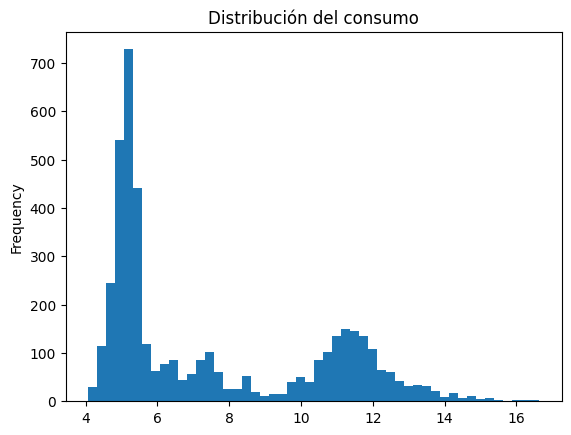

In [12]:
df["potencia"].plot(kind="hist", bins=50, title="Distribución del consumo")

#### ¿Qué observamos?

**Distribución bimodal**

Hay dos picos claros:

* Uno muy marcado alrededor de 5.5 kWh
* Otro más disperso y más amplio entre 11 y 13 kWh

Esto sugiere que hay dos patrones de funcionamiento distintos, posiblemente:

* Modo reposo o stand-by (consumo bajo, frecuente)
* Modo de uso activo, cuando el edificio está operativo (consumo más alto)

**Sesgo a la derecha**

* La distribución presenta una cola larga hacia valores altos, aunque con baja frecuencia (≥14 kWh).
* Estos podrían ser picos aislados de consumo, posiblemente anómalos o poco habituales.

**Rango de consumo**

* Valores observados entre 4 y 16.5 kWh
* La mayor concentración está entre 5 y 6 kWh, lo que puede considerarse como el comportamiento normal de base.



#### Boxplot para ver outliers

<Axes: >

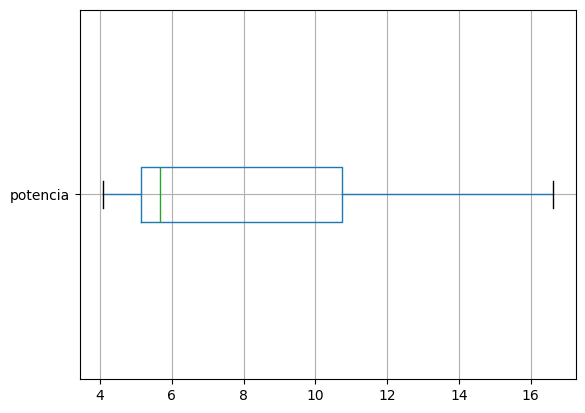

In [13]:
df.boxplot(column="potencia", vert=False)

#### ¿Qué representa?
El eje horizontal representa los valores de potencia (en kWh o similar).

* La caja representa el rango intercuartílico (IQR), es decir, entre el primer cuartil (Q1) y el tercero (Q3).
* La línea central dentro de la caja es la mediana.
* Los “bigotes” (líneas horizontales a izquierda y derecha) se extienden hasta 1.5 veces el IQR.
* Los puntos fuera de los bigotes se consideran posibles valores atípicos (outliers).

#### ¿Qué observamos?
**Caja centrada entre ~5.5 y ~10.5 kWh**
* Esto indica que el 50% central de los datos está dentro de ese rango.
* Coincide con el primer pico del histograma.

**Mediana cercana al inicio del IQR (~5.7 kWh)**

* Sugiere una asimetría hacia la derecha: la mayoría de los datos están en valores bajos, con algunos valores altos poco frecuentes.

**Bigotes extendidos hasta ~4 y ~16.5 kWh**
No se representan puntos fuera de los bigotes, pero es probable que existan valores escasos y extremos cercanos a esos márgenes.


---

### 🔍 4. Ideas para detección manual de anomalías

* Si `potencia > Q3 + 1.5 * IQR` → posible pico anómalo
* Si `potencia < Q1 - 1.5 * IQR` → posible caída brusca
* Si `hora in [0, 4]` y `potencia > X` → actividad fuera de horario

---